# ANZ Prediction Model

### Importing required libraries

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
pd.options.display.max_columns= None
pd.options.display.max_rows= None
pd.options.display.float_format = '{:.6f}'.format

import statsmodels
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

### Data loading and Treatment

In [42]:
df=pd.read_excel("ANZ synthesised transaction dataset.xlsx")
df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.000000,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,nan,Diana,35.390000,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.250000,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.000000,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,nan,Diana,21.200000,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.190000,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.000000,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,nan,Michael,5.710000,2018-08-01,M,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.420000,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.000000,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,nan,Rhonda,2117.220000,2018-08-01,F,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.900000,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.000000,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,nan,Diana,17.950000,2018-08-01,F,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.250000,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


In [43]:
df.shape

(12043, 23)

In [44]:
df.dtypes

status                       object
card_present_flag           float64
bpay_biller_code             object
account                      object
currency                     object
long_lat                     object
txn_description              object
merchant_id                  object
merchant_code               float64
first_name                   object
balance                     float64
date                 datetime64[ns]
gender                       object
age                           int64
merchant_suburb              object
merchant_state               object
extraction                   object
amount                      float64
transaction_id               object
country                      object
customer_id                  object
merchant_long_lat            object
movement                     object
dtype: object

In [27]:
df.isnull().sum()

status                   0
card_present_flag     4326
bpay_biller_code     11158
account                  0
currency                 0
long_lat                 0
txn_description          0
merchant_id           4326
merchant_code        11160
first_name               0
balance                  0
date                     0
gender                   0
age                      0
merchant_suburb       4326
merchant_state        4326
extraction               0
amount                   0
transaction_id           0
country                  0
customer_id              0
merchant_long_lat     4326
movement                 0
dtype: int64

In [45]:
df['gender'].value_counts()

M    6285
F    5758
Name: gender, dtype: int64

In [47]:
df['gender']=df['gender'].map({"M":1,"F":0})

### Making salary column for each customer for our regression

In [48]:
# selecting required columns
df=df[["customer_id","age","txn_description","balance","amount","gender"]]
df_salary = df[df["txn_description"]=="PAY/SALARY"].groupby("customer_id").mean()
df_salary.head()

,age,balance,amount,gender
customer_id,,,,
CUS-1005756958,53,4718.665385,970.470000,0
CUS-1117979751,21,11957.202857,3578.650000,1
CUS-1140341822,28,5841.720000,1916.510000,1
CUS-1147642491,34,8813.467692,1711.390000,0
CUS-1196156254,34,23845.717143,3903.730000,0


In [49]:
#making a new column total salary of 3 months
salary = []
for customer_id in df["customer_id"]:
    salary.append(int(df_salaries.loc[customer_id]["amount"]))

 #diving by 3 to get monthly salary since data is for 3 months
month_sal = [x/3 for x in salary]
df["monthly_salary"] = month_sal

In [50]:
df_reg = df.groupby("customer_id").mean()
df_reg.head()

,age,balance,amount,gender,monthly_salary
customer_id,,,,,
CUS-1005756958,53,2275.852055,222.862603,0,323.333333
CUS-1117979751,21,9829.929000,339.843700,1,1192.666667
CUS-1140341822,28,5699.212250,212.632500,1,638.666667
CUS-1147642491,34,9032.841186,245.600169,0,570.333333
CUS-1196156254,34,22272.433755,147.145796,0,1301.000000


In [51]:
df_reg.isnull().sum()

age               0
balance           0
amount            0
gender            0
monthly_salary    0
dtype: int64

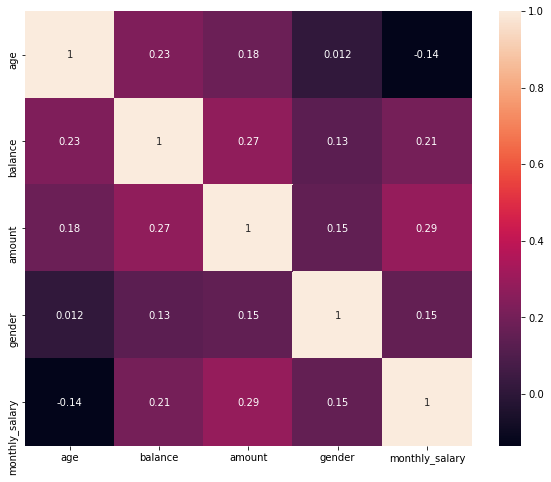

In [53]:
#checking pearsons correlation

plt.figure(figsize=(10,8))
sns.heatmap(df_reg.corr(),annot=True)
plt.show()

### Regression model

In [64]:
# scaling the dependant variables and building the model
sc=StandardScaler()
num_data=df_reg.drop(['monthly_salary'],axis=1)
num_data_sc=sc.fit_transform(num_data)
num_dat=pd.DataFrame(num_data)
num_dat.columns=num_data.columns

X=num_dat
y=df_reg['monthly_salary']

Xc=sm.add_constant(X)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(Xc,y,random_state=10, test_size=0.35)
linreg = LinearRegression()
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(65, 5)
(35, 5)
(35,)


In [69]:
model = linreg.fit(X_train,y_train)
print(f'R^2 score for train: {linreg.score(X_train, y_train)}')
print(f'R^2 score for test: {linreg.score(X_test, y_test)}')

R^2 score for train: 0.3000166658298785
R^2 score for test: -0.22943473900383338


In [70]:
model=sm.OLS(y_train,X_train).fit()

In [71]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         monthly_salary   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     6.429
Date:                Thu, 25 Mar 2021   Prob (F-statistic):           0.000225
Time:                        14:08:12   Log-Likelihood:                -477.83
No. Observations:                  65   AIC:                             965.7
Df Residuals:                      60   BIC:                             976.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        482.8420    163.069      2.961      0.0

In [80]:
print("The r-squared of the model is",model.rsquared)

The r-squared of the model is 0.3000166658298786


### prediction using DecisionTree

In [76]:
dt =DecisionTreeRegressor()
dt_model=dt.fit(X_train, y_train)
print(f'R^2 score for train: {dt.score(X_train, y_train)}')
print(f'R^2 score for test: {dt.score(X_test, y_test)}')

R^2 score for train: 1.0
R^2 score for test: -0.5571103580355119


In [79]:
pred=dt.predict(X_test)
dt.score(X_test, y_test)

-0.5571103580355119